# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [1]:
push!(LOAD_PATH, ".")
using PreprocTools
using HDF5, PyPlot, Statistics
using ArraySetTools

La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [2]:
abrestring="/home/karel/BRWFiles/Facilitada/19115s1cut_single_event.brw"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/Facilitada/19115s1cut_single_event"

In [3]:
tamax=400*1024*1024  #maximo tamaño tolerable de archivo
tam=filesize(abrestring)
cachos=div(tam,tamax)+1

1

In [4]:
Datos=AbreyCheca(abrestring)

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5F.c line 370 in H5Fis_hdf5(): unable open file
    major: File accessibilty
    minor: Not an HDF5 file
  #001: H5Fint.c line 802 in H5F__is_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #002: H5FD.c line 734 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = '/home/karel/BRWFiles/Facilitada/19115s1cut_single_event.brw', errno = 2, error message = 'No existe el fichero o el directorio', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


ErrorException: Cannot access file /home/karel/BRWFiles/Facilitada/19115s1cut_single_event.brw

In [9]:
### parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
retrazo=round(Int, ceil(5*freq))
final=round(Int, ceil(60*freq))
latencia=round(Int, ceil(1.5*freq))


11

In [10]:
cuadrosmax=Datos["numcuadros"]
tiempototalms=round(cuadrosmax/freq; digits=1) 
println("Tienes ", cuadrosmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 2000 cuadros de muestreo a 7.0221 cuadros por milisegundo
Esto corresponde a  284.8ms.


In [11]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.1966960966343147

In [12]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;

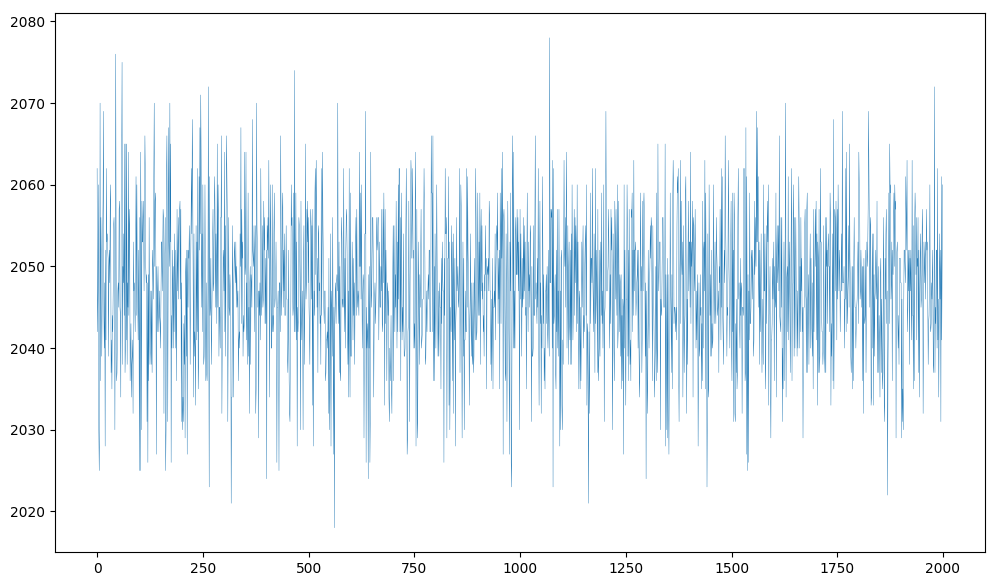

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efc0069af98>

In [13]:
figure(figsize=(12,7))

plot(DatosCrudosArreglados[4,1:2000], lw=0.3)

In [14]:
DatosCrudosArreglados[1,1]==0

false

In [15]:
cachos

1

In [16]:
# si la fraccion de memoria libre es inferior a 0.2, tenemos que cortar un cacho de los datos. Que tan chico el cacho depende... 
# toca probar
if cachos > 1
    ## escoga el usuario un cacho para trabajar entre 1 y cachos
    cacho=1
    pedazo=round(Int, Datos["numcuadros"]/cachos)
    if cacho < cachos # si no es el ultimo cacho
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1)*pedazo):cacho*pedazo]
    else
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1))*pedazo:cuadrosmax]
    end
    palabritaespecial="/Cacho_$(cacho)_"
else
    palabritaespecial="/Completo_"
end

#    end;
# Liberar memoria
Datos["DatosCrudos"]=0
println( "Este será el identificador del archivo en cachos: ", palabritaespecial)


Este será el identificador del archivo en cachos: /Completo_


In [17]:
size(DatosCrudosArreglados)

(4096, 2000)

In [18]:
 DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
# libera memoria
DatosCrudosArreglados=0

0

In [19]:
ncuadros=size(DatosCentrados)[3]

2000

In [20]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
PruebaRespuesta=buscaCanalPicos(DatosCentrados, 1, 200, freq,-110,-900)
# y luego los saturados
iniciobusqueda=1
finbusqueda=282
satu=BuscaSaturados(DatosCentrados,iniciobusqueda,finbusqueda,freq,1000)
numerosaturados=length(satu)
println("Encontramos ", numerosaturados, " canales probablemente saturados.")
println("Encontramos ", length(PruebaRespuesta), " canales probablemente con actividad.")


Estoy buscando del cuadro 8 al , 1405
Encontramos 109 canales probablemente saturados.
Encontramos 534 canales probablemente con actividad.


In [21]:
quietos=BuscaSaturadosStd(DatosCentrados, iniciobusqueda,finbusqueda, freq, 15,10000)
intensos=BuscaSaturadosStd(DatosCentrados, iniciobusqueda, finbusqueda, freq, 0, 30)
numerosaturados=length(quietos)
println("Encontramos ", numerosaturados, " canales muy quietos")
numerosaturados=length(intensos)
println("Encontramos ", numerosaturados, " canales muy intensos")



Encontramos 99 canales muy quietos
Encontramos 594 canales muy intensos


In [22]:
intersect(quietos, intensos)

Set(Array{Int8,1}[])

In [23]:
ruidosos=BuscaRuidosos(DatosCentrados, iniciobusqueda, finbusqueda, freq,200,15)
numerosaturados=length(ruidosos)
println("Encontramos ", numerosaturados, " canales con ruido alto")

Encontramos 285 canales con ruido alto


### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [24]:
DesviacionPorCanal=zeros(64,64)
for j=1:64
    for k=1:64
        ChorizoExemplo=vec(DatosCentrados[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
    end
end

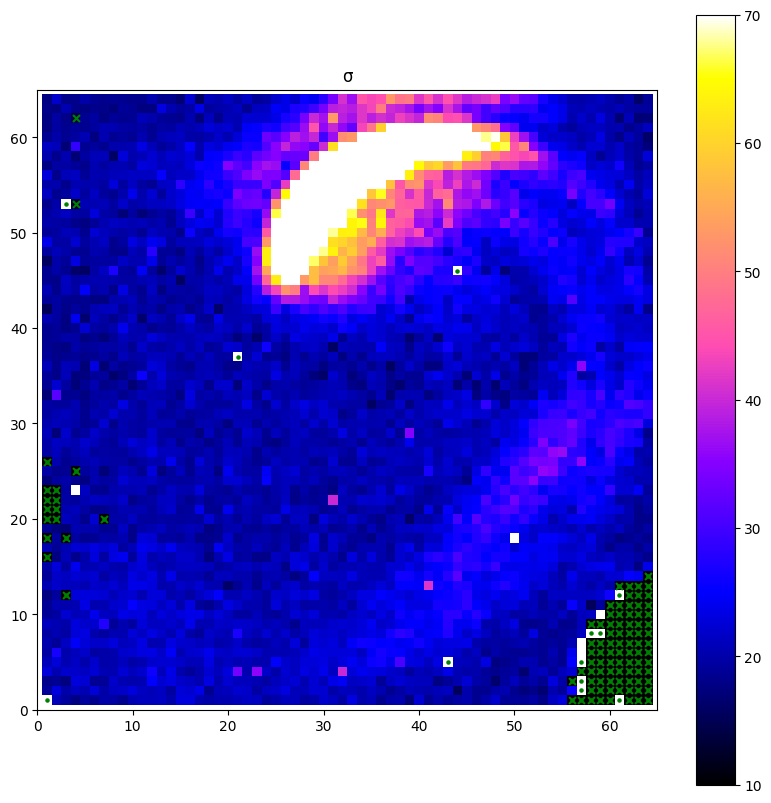

PyObject <matplotlib.collections.PathCollection object at 0x7efbe1d465c0>

In [41]:
figure(figsize=(10,10))
xlim(0,65)
ylim(0,65)
title("σ")
limites=70
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="gnuplot2", 
                      vmin=10,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar()

x=[]
y=[]
for j in PruebaRespuesta
  append!(x,j[2])
   append!(y,j[1])
end


x2=[]
y2=[]
for j in satu
  append!(x2,j[2])
   append!(y2,j[1])
end


x3=[]
y3=[]
for j in quietos
  append!(x3,j[2])
   append!(y3,j[1])
end


x4=[]
y4=[]
for j in intensos
  append!(x4,j[2])
   append!(y4,j[1])
end


x5=[]
y5=[]
for j in ruidosos
  append!(x5,j[2])
   append!(y5,j[1])
end





#scatter(x,y, marker="o",c="lightblue", s=15)
scatter(x2,y2, marker="o",c="green", s=5)
scatter(x3,y3, marker="x",c="green", s=25)
#scatter(x4,y4, marker="+",c="lightblue", s=25)
#scatter(x5,y5, marker="v",c="green", s=25)



"ruidosos" parece ser totalmente redundante. No aporta nada que no sea JUSTO lo que no nos interesa: la union de lo peor y lo mejor.
Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [40]:
egtrazo=DatosCentrados[23,4,:];

In [43]:
using Statistics

In [44]:
mean(egtrazo)

600.60443f0

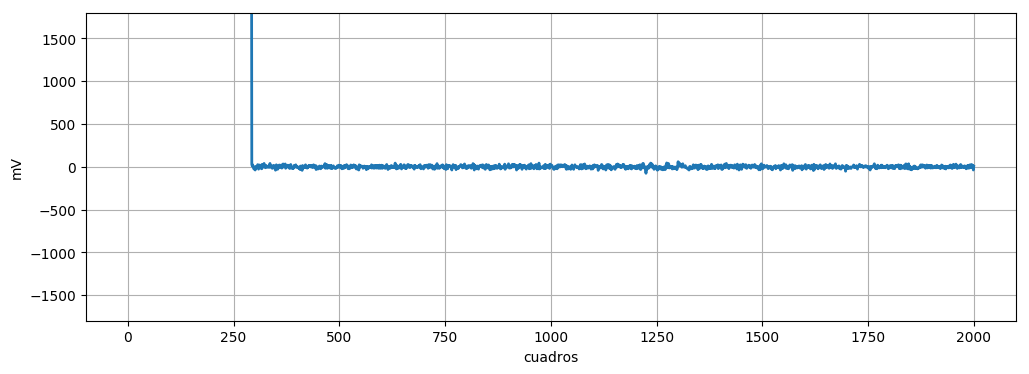

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efbe1cb60b8>

In [42]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-1800,1800)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=1
hasta=2000
#intervalo=1:cacho
intervalo=desde:hasta
grid()
plot(intervalo,egtrazo[intervalo], lw=2)

In [29]:
mal=union(quietos, satu)
buenos=union(intensos, PruebaRespuesta)
setdiff!(buenos, mal)

Set(Array{Int8,1}[[51, 20], [62, 26], [11, 45], [57, 39], [24, 48], [30, 51], [61, 48], [57, 42], [55, 35], [57, 55]  …  [9, 42], [34, 64], [23, 48], [59, 28], [44, 28], [60, 31], [31, 51], [43, 28], [54, 55], [50, 32], [61, 47]])

In [30]:
malforsave=elemtorow(mal)
buenforsave=elemtorow(buenos);

In [31]:
size(DatosCentrados)

(64, 64, 2000)

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [32]:
dirname(stringgeneral), basename(stringgeneral)

("/home/karel/BRWFiles/Facilitada", "19115s1cut_single_event")

In [33]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
outname=string(dirgen,palabritaespecial, basegen, "_preproc.h5")
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPSaturados" => DatosCentrados[:,:,desde:hasta],
     "desde" => desde,
    "hasta" => hasta,
     "freq" =>freq,
     "CanalesBuenos" => buenforsave,
     "CanalesMalos" => malforsave)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)

/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5
abriendo los datos CanalesMalos
abriendo los datos desde
abriendo los datos hasta
abriendo los datos LFPSaturados
abriendo los datos freq
abriendo los datos CanalesBuenos
hemos guardado este cacho en el archivo /home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5


In [34]:
typeof(listaaguardar)

Dict{String,Any}

In [35]:
freq

7.022058198545425